<a href="https://colab.research.google.com/github/martintmv-git/RB-IBDM/blob/main/GSL/GroundedSAM_LaMa_background_subtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install environment requirements

In [ ]:
#GroundedSAM
%cd /content
!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything
%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything

#LaMa
!pip install -q simple-lama-inpainting

#EXIF
!pip install -q piexif

/content
fatal: destination path 'Grounded-Segment-Anything' already exists and is not an empty directory.
/content/Grounded-Segment-Anything
/content/Grounded-Segment-Anything/GroundingDINO
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
/content/Grounded-Segment-Anything/segment_anything
  Preparing metadata (setup.py) ... done
/content/Grounded-Segment-Anything


# Add imports

In [ ]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
import PIL
from PIL import Image, ImageDraw, ImageFont, ImageChops, ImageEnhance
import piexif
from torchvision.ops import box_convert

# GroundingDINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

from huggingface_hub import hf_hub_download

import supervision as sv

# SAM
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt

# LaMa
import requests
import torch
from io import BytesIO
from simple_lama_inpainting import SimpleLama

# Load the models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## GroundingDINO

In [ ]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [ ]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


## SAM

In [ ]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

--2024-06-26 20:33:39--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.108, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   170MB/s    in 18s     

2024-06-26 20:33:57 (137 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



## LaMa

In [ ]:
simple_lama = SimpleLama()

# Inference

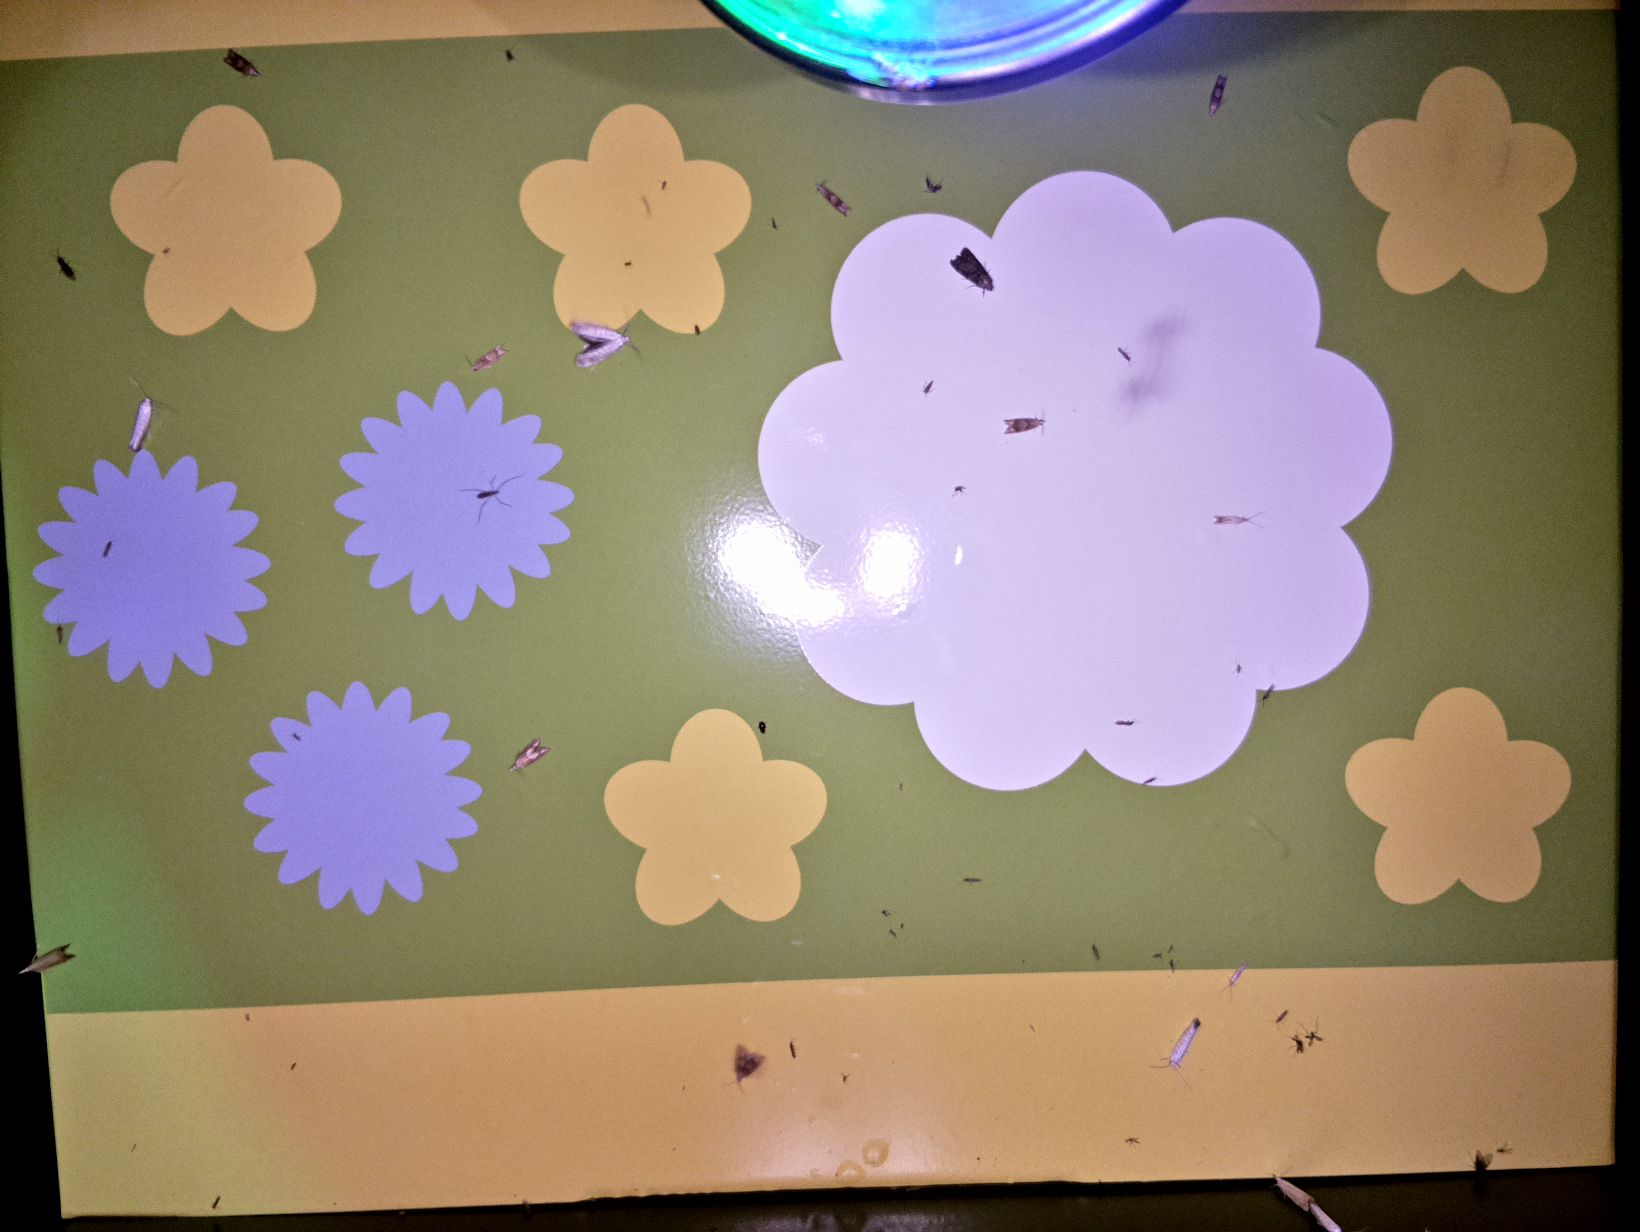

In [ ]:
# Load image
local_image_path = '/content/drive/MyDrive/Fontys/Fontys_Sem7/insect_detection/GSL/GSL_test_images/20230714235848.jpg'
image_source, image = load_image(local_image_path)
Image.fromarray(image_source)

## GroundingDINO

In [ ]:
# detect insects using GroundingDINO
def detect(image, model, text_prompt = 'insect . flower . cloud', box_threshold = 0.15, text_threshold = 0.15):
  boxes, logits, phrases = predict(
      image=image,
      model=model,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes, phrases

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


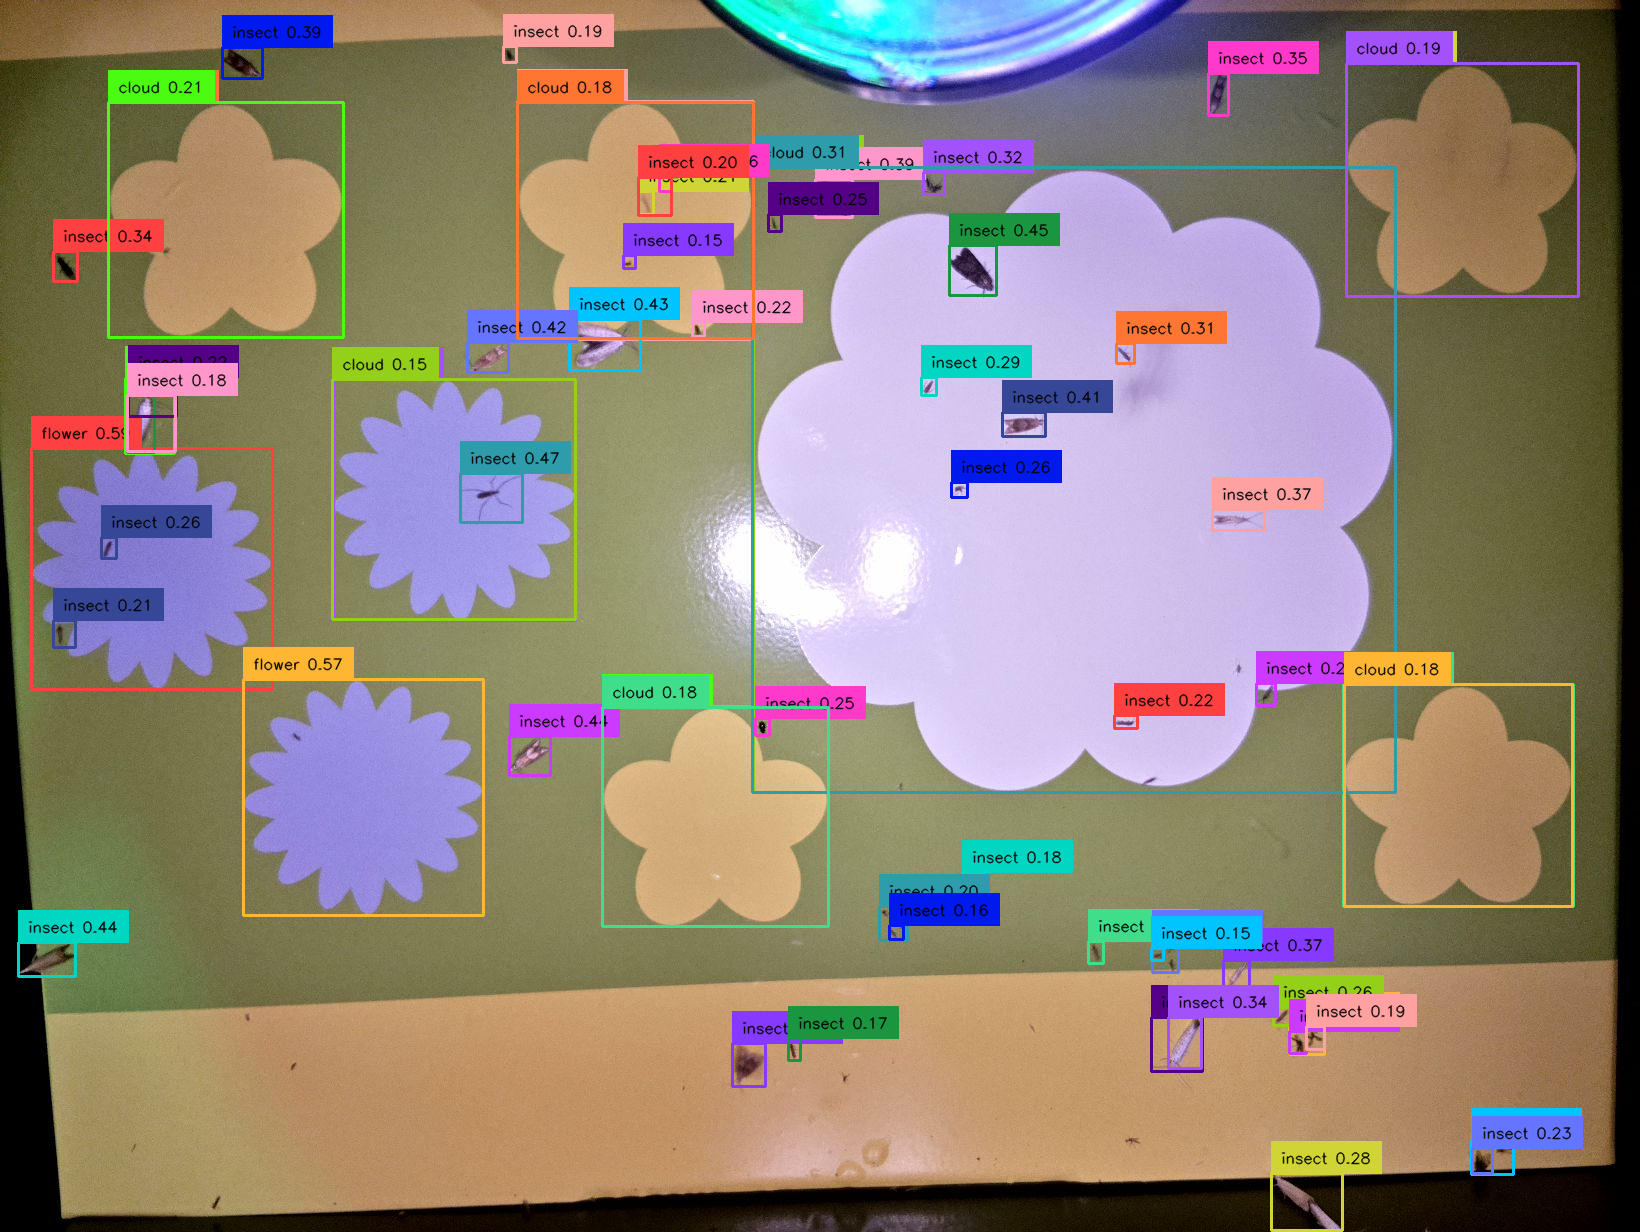

In [ ]:
annotated_frame, detected_boxes, phrases = detect(image, model=groundingdino_model)
Image.fromarray(annotated_frame)

## SAM

In [ ]:
indices = [i for i, s in enumerate(phrases) if 'insect' in s]

In [ ]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = True,
      )
  return masks.cpu()

def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

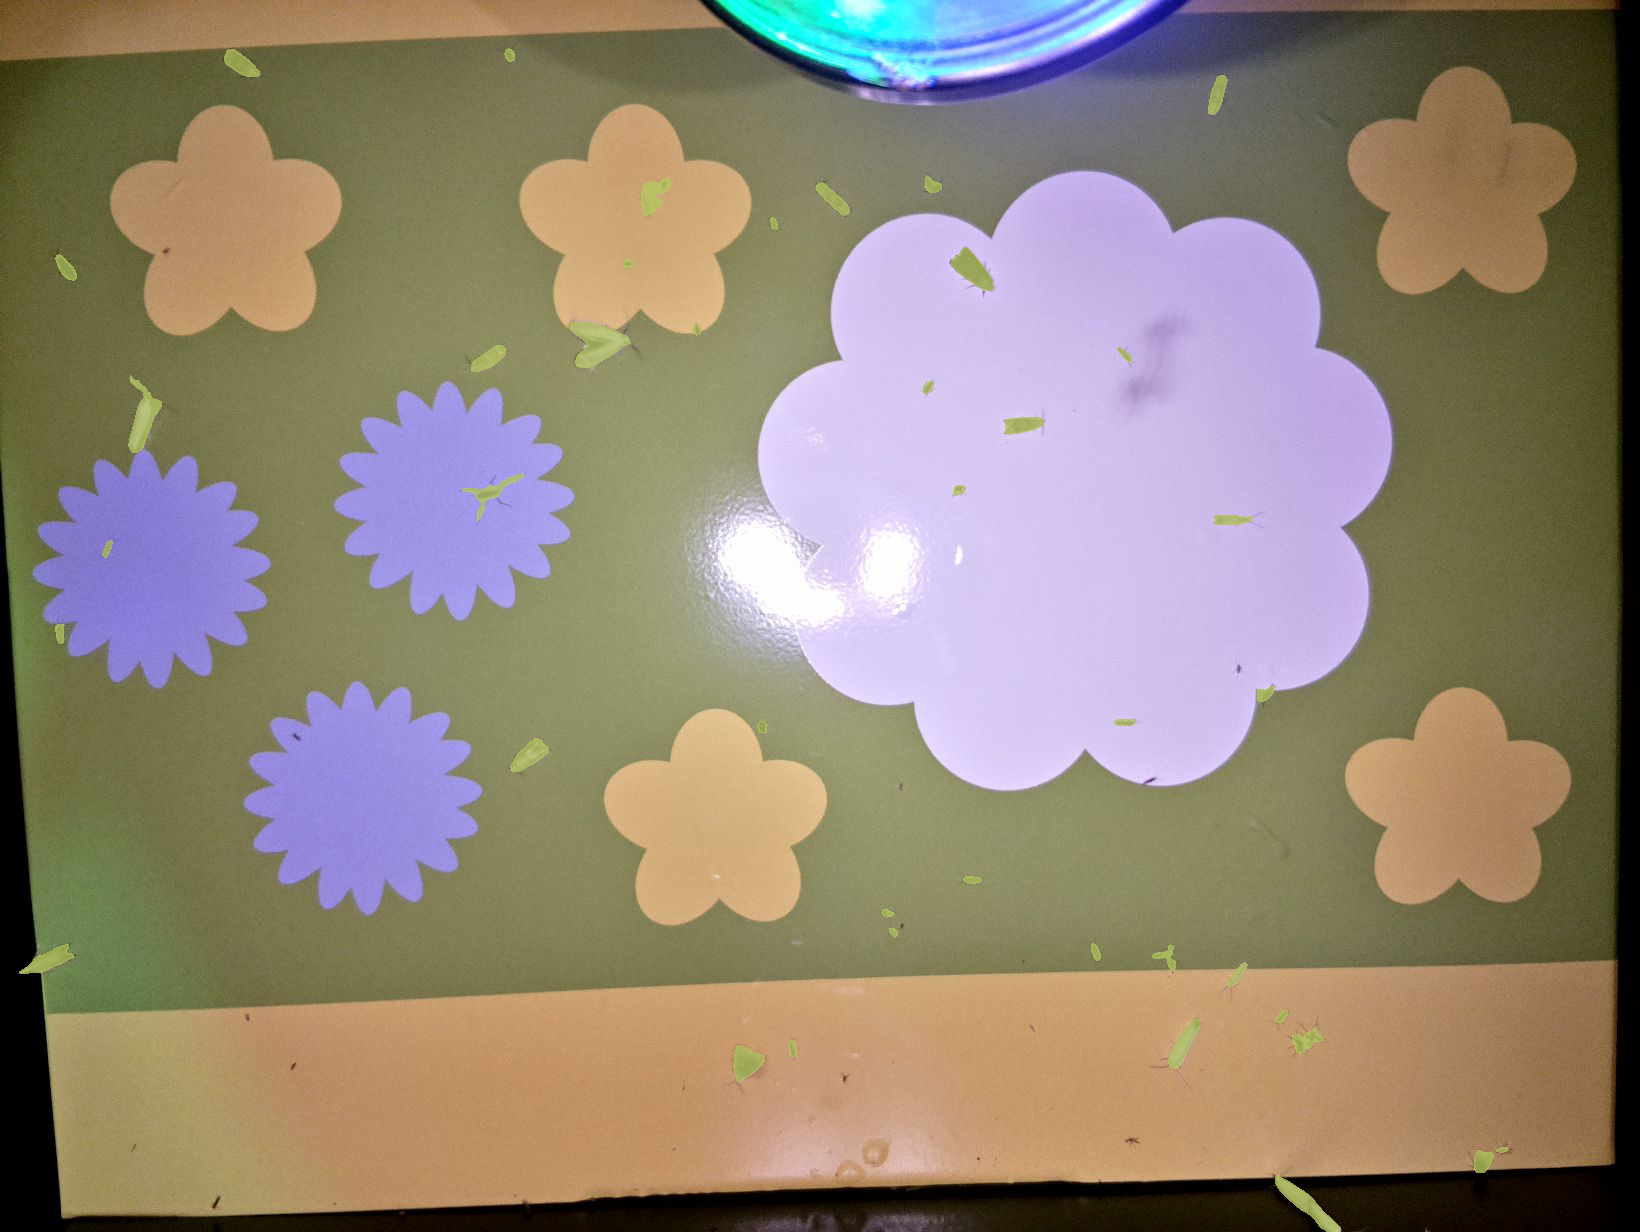

In [ ]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes[indices])

# combine all masks into one for easy visualization
final_mask = None
for i in range(len(segmented_frame_masks) - 1):
  if final_mask is None:
    final_mask = np.bitwise_or(segmented_frame_masks[i][0].cpu(), segmented_frame_masks[i+1][0].cpu())
  else:
    final_mask = np.bitwise_or(final_mask, segmented_frame_masks[i+1][0].cpu())

annotated_frame_with_mask = draw_mask(final_mask, image_source)
Image.fromarray(annotated_frame_with_mask)

## LaMa

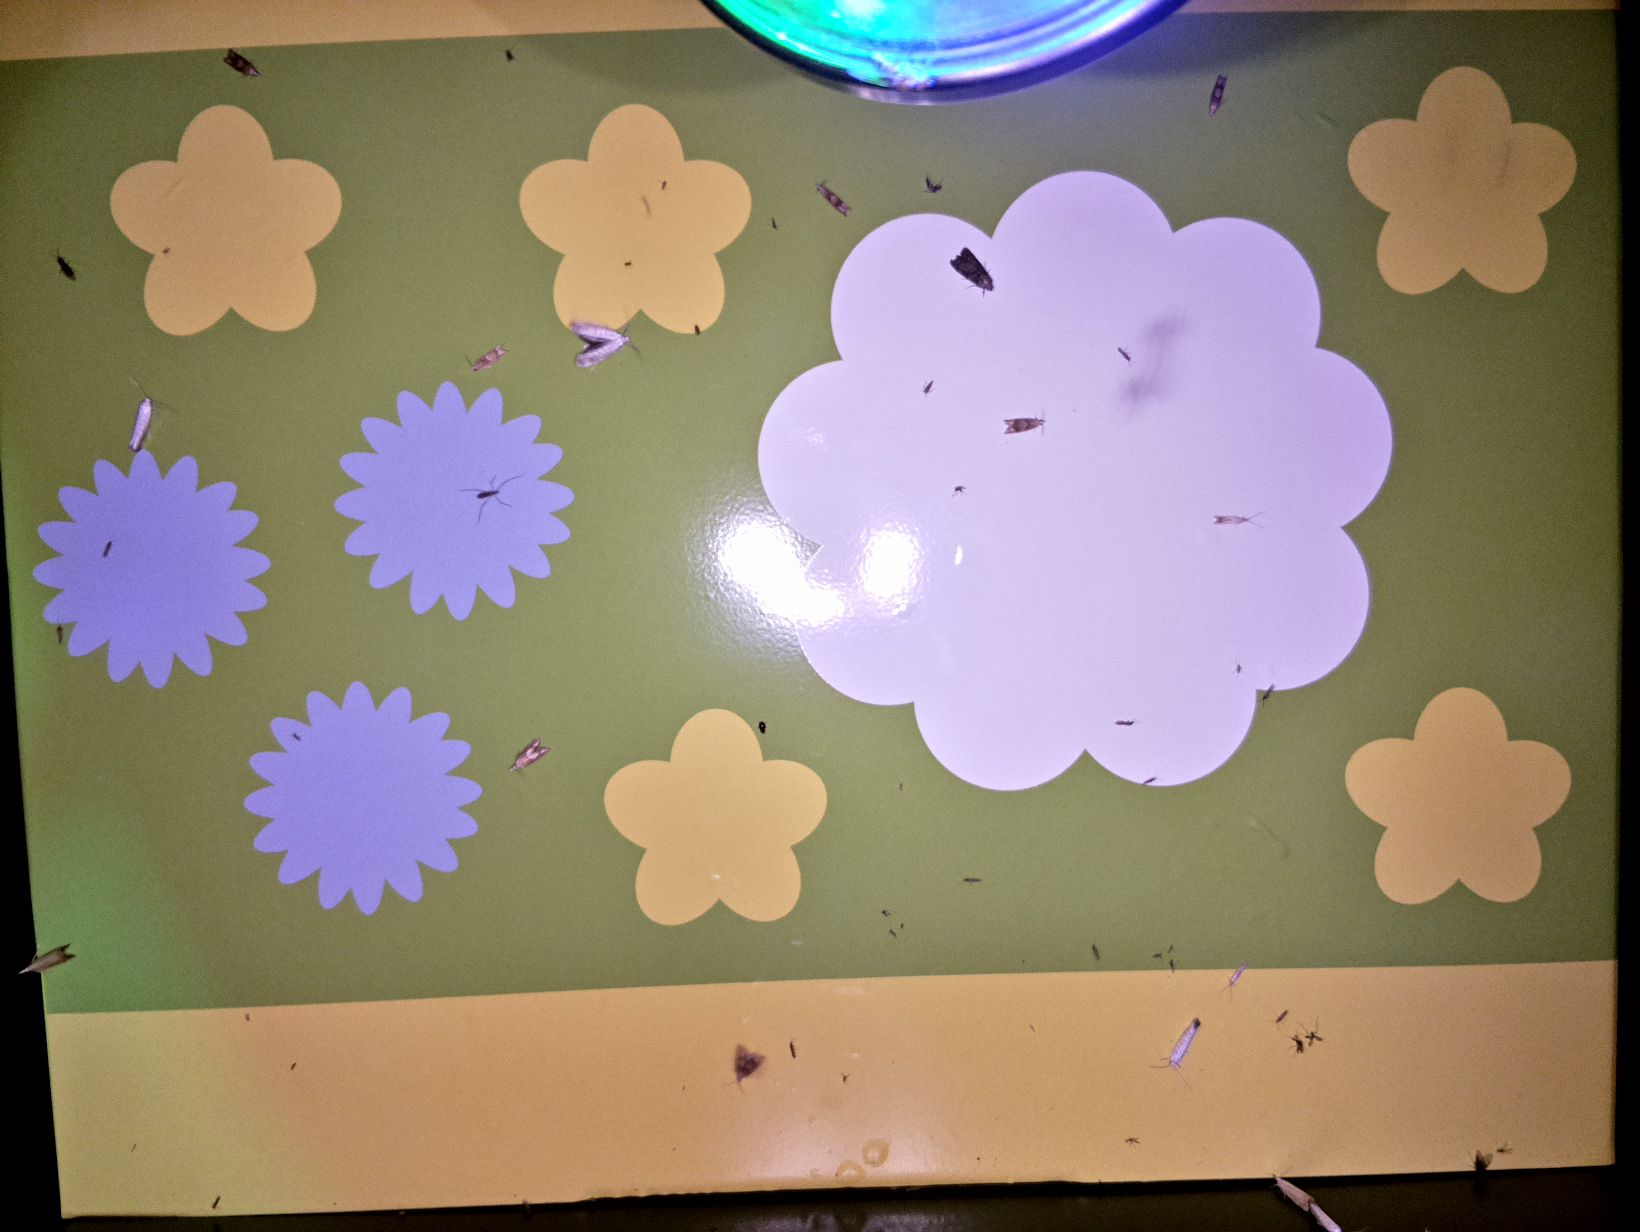

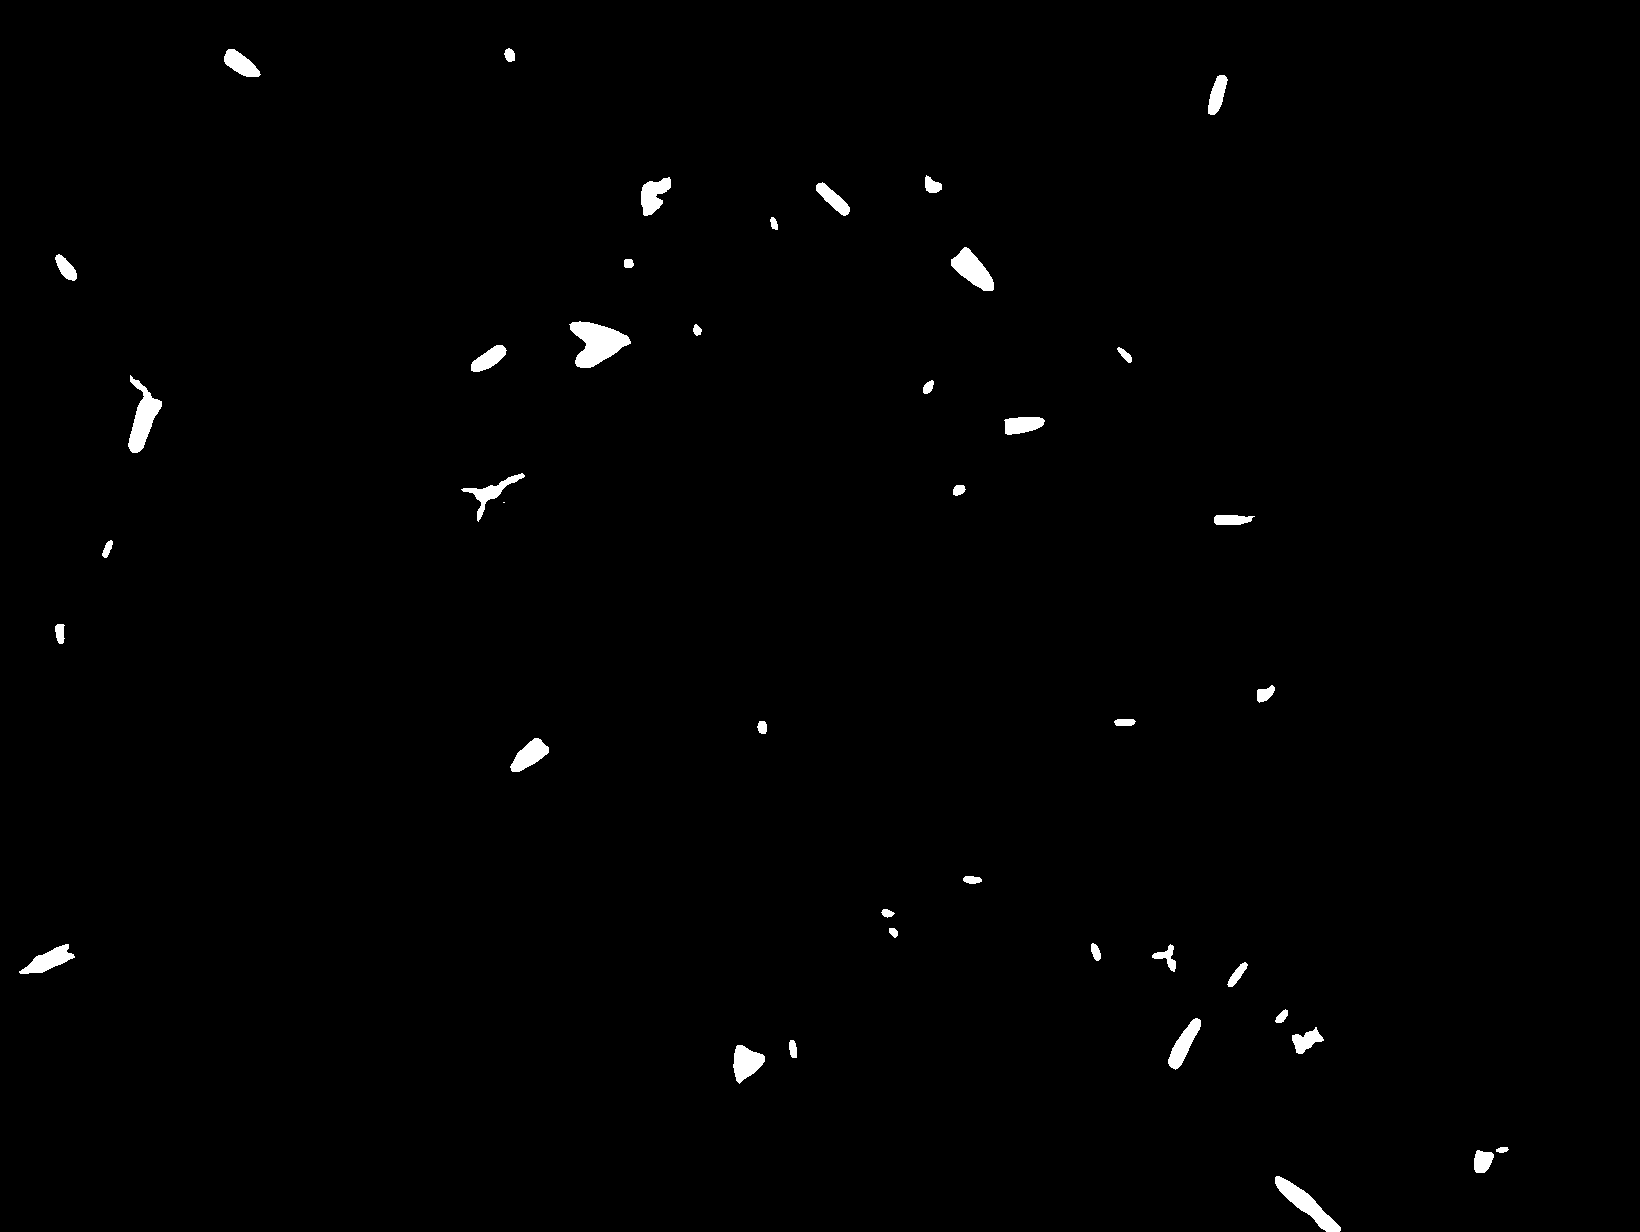

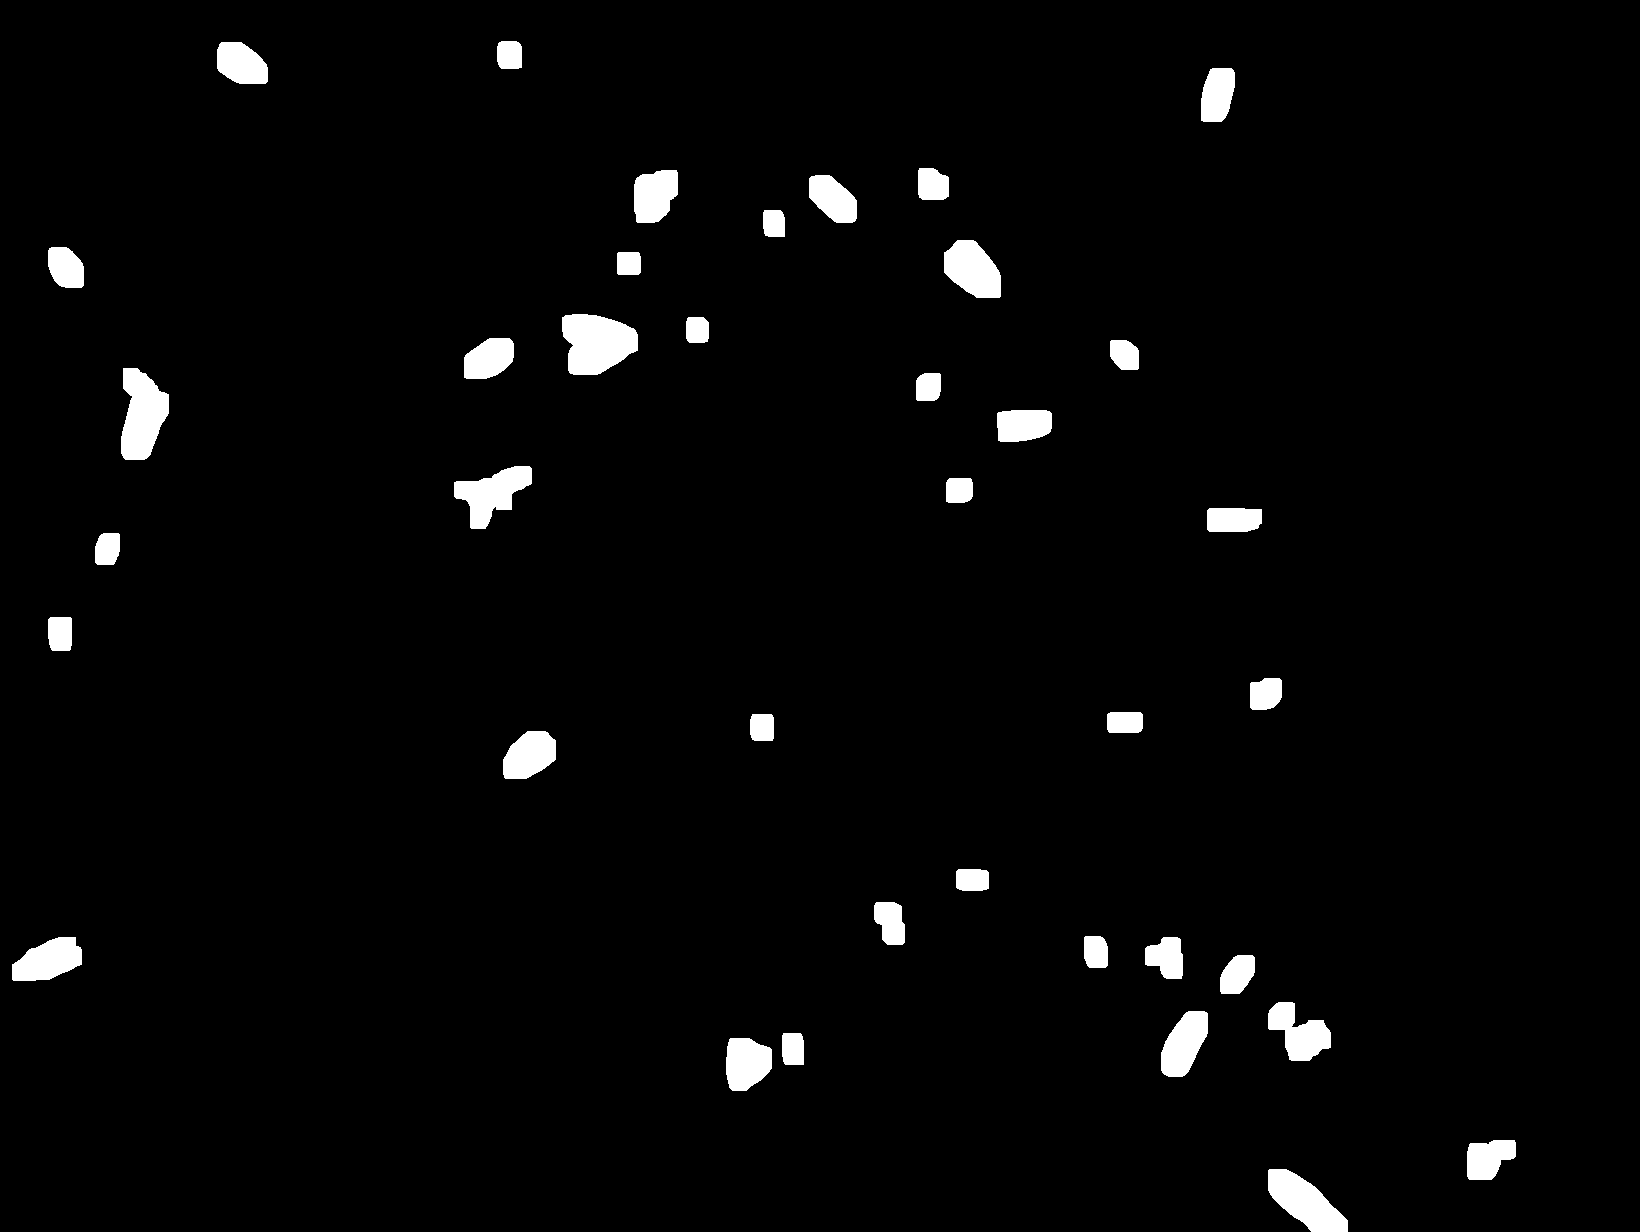

In [ ]:
def dilate_mask(mask, dilate_factor=15):
    mask = mask.astype(np.uint8)
    mask = cv2.dilate(
        mask,
        np.ones((dilate_factor, dilate_factor), np.uint8),
        iterations=1
    )
    return mask

# original image
image_source_pil = Image.fromarray(image_source)

# create mask image
mask = final_mask.numpy()
mask = mask.astype(np.uint8) * 255
image_mask_pil = Image.fromarray(mask)

# dilate mask
mask = dilate_mask(mask)
dilated_image_mask_pil = Image.fromarray(mask)

display(*[image_source_pil, image_mask_pil, dilated_image_mask_pil])

In [ ]:
result = simple_lama(image_source, dilated_image_mask_pil)
result.save('/content/drive/MyDrive/Fontys/Fontys_Sem7/insect_detection/GSL/GSL_test_images/20230714235848_lama.jpg')

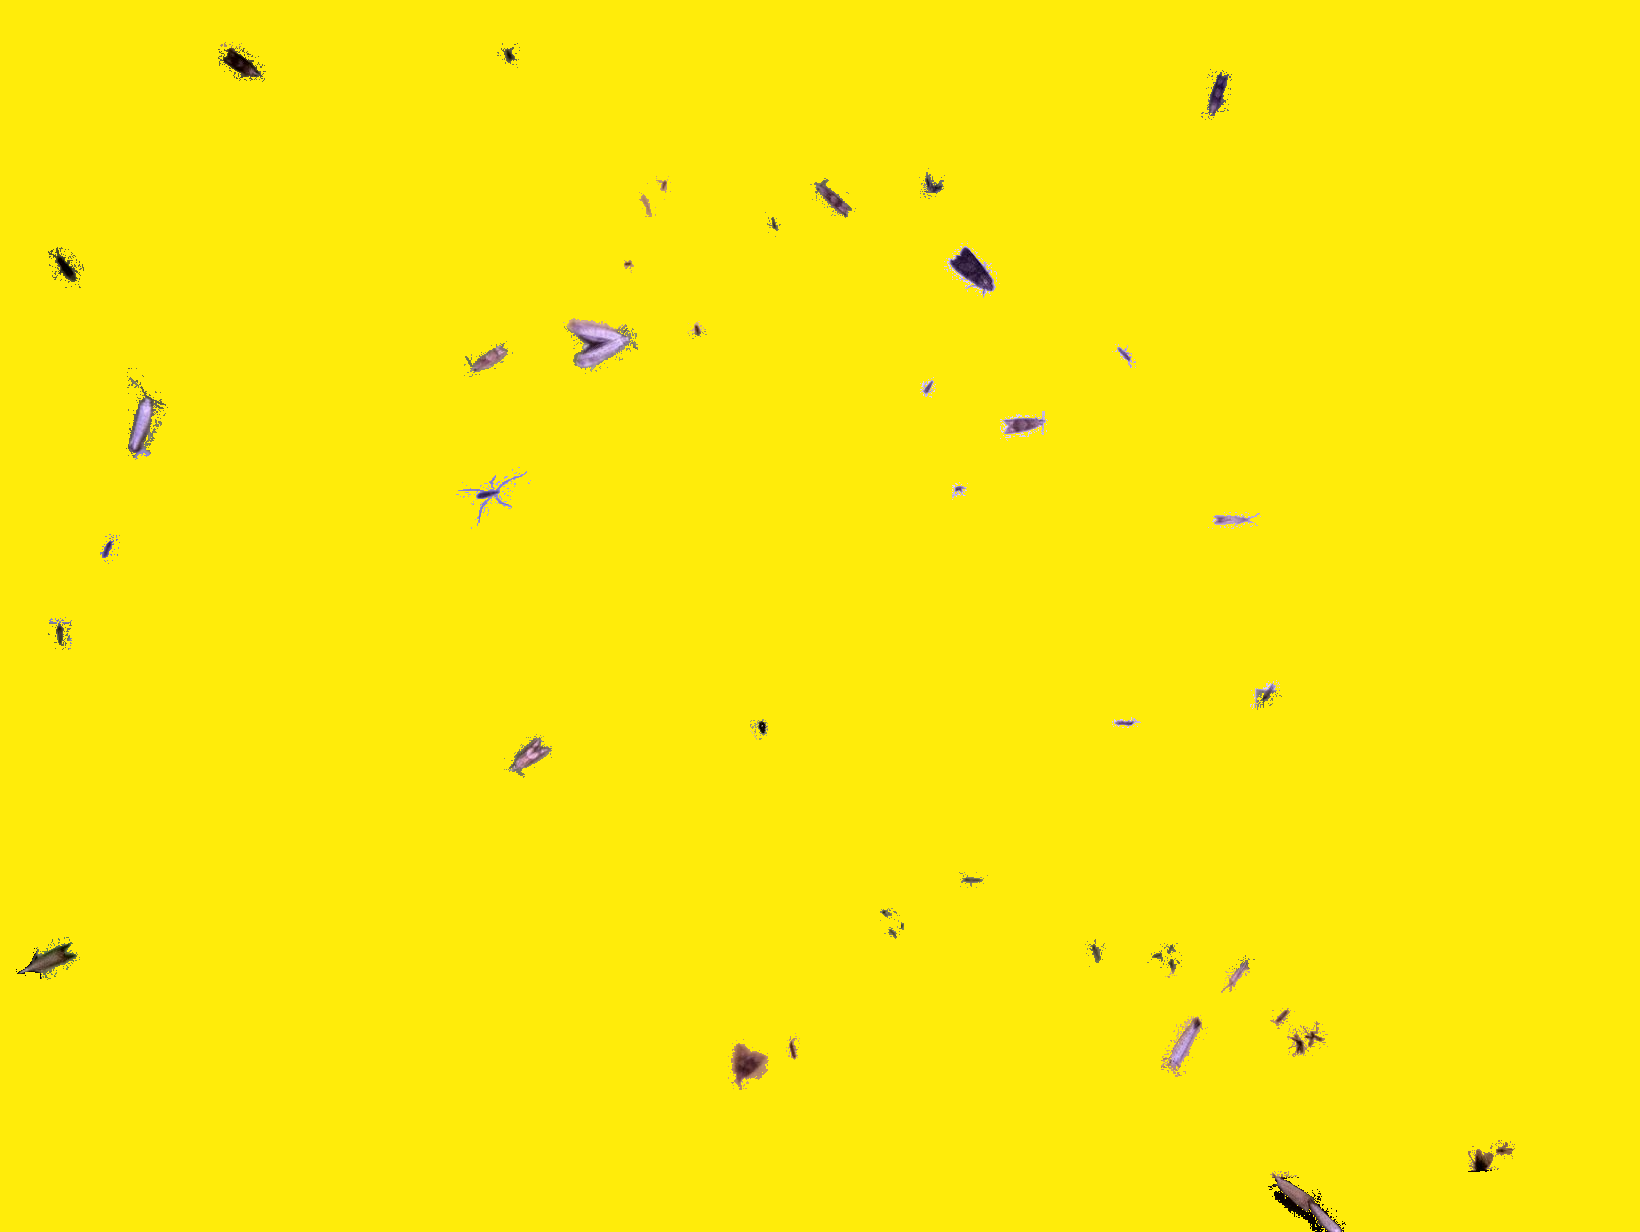

In [ ]:
from PIL import Image, ImageChops, ImageEnhance

# Load iam
img1 = Image.fromarray(image_source)
img2 = result

diff = ImageChops.difference(img2, img1)
diff

threshold = 7
# Grayscale
diff2 = diff.convert('L')
# Threshold
diff2 = diff2.point( lambda p: 255 if p > threshold else 0 )
# # To mono
diff2 = diff2.convert('1')
diff2

img3 = Image.new('RGB', img1.size, (255, 236, 10))
diff3 = Image.composite(img1, img3, diff2)
diff3.save('/content/drive/MyDrive/Fontys/Fontys_Sem7/insect_detection/GSL/GSL_test_images/20230714235848_yellow_l.jpg')
piexif.transplant(local_image_path, '/content/drive/MyDrive/Fontys/Fontys_Sem7/insect_detection/GSL/GSL_test_images/20230714235848_yellow_l.jpg')

diff3